# Time Series Forecast: Features &rarr; Emissions (monthly)

### To evaluate:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 

### Import libraries

In [171]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import EarlyStopping
import json
import random
from keras import backend as K
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D



### Some useful functions

In [172]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [173]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title = plttitle)
    ax.set(ylabel = metric[0].swapcase() + metric[1:])
    ax.set(xlabel = 'Epoch')
    ax.legend(['train', 'val'], loc = 'upper right')

### Read in input data (features) - X

In [174]:
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        continue
        #print(f"Feature not used: {i}")
        
date_first = feature_data.index[0]
date_last = feature_data.index[-1]
first_date = date_first.strftime("%m/%Y")
last_date = date_last.strftime("%m/%Y")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input data (features): {feature_data.shape}")
print(f"Input data starts at: {first_date} and ends at: {last_date}")

Shape input data (features): (111, 40)
Input data starts at: 01/2011 and ends at: 03/2020


### Read in target data (emissions) - y

In [175]:
emission_data = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
print(emission_data.head())
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
print(emission_data.shape)

# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data (emissions): {emission_data.shape}")

      date  E_Mio.tonnes_CO2  M_Mio.tonnes_CO2  ECO_Mio.tonnes_CO2  \
0  1990-01         59.831181         11.965386           32.015404   
1  1990-02         57.338215         12.509267           31.287781   
2  1990-03         52.352284         13.325089           30.560158   
3  1990-04         49.859318         14.004941           29.104913   
4  1990-05         44.873386         14.276881           27.649667   

   Total_CO2_Emission  
0          103.811971  
1          101.135264  
2           96.237531  
3           92.969171  
4           86.799934  
(372,)
Shape output data (emissions): (111,)


### Data preparation

In [176]:
def prepare_data(input_data, output_data, look_back=1, horizon=1, shuffle=False, apply_pca=False, pca_comp=10, scaler = None):
    
    dataX, dataY = [], []
    
    # Check data requirements
    if len(input_data) != len(output_data):
        raise ValueError('Input and ouput do not have same length!')
    
    # Apply PCA to data
    if apply_pca:
        pca = PCA(n_components = pca_comp)
        input_data = pca.fit_transform(input_data)
        print(f"PCA applied on feature input data - New feature input shape: {input_data.shape}")
        
    # Apply data scaler
    if scaler == None:
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'Standard':
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'MinMax':
        scaler = MinMaxScaler()
        input_data = scaler.fit_transform(input_data)
    else:
        raise ValueError('scaler variable has to be either \'Standard\' or \'MinMax\'!')           
    
    # Apply 'windowing' to data
    for i in range(len(input_data)-look_back-horizon):
        dataX.append(input_data[i:(i+look_back)])
        dataY.append(output_data[(i+look_back):(i+look_back+horizon)])
    
    # Shuffle data
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
        
    return np.array(dataX), np.array(dataY)

### Define dataset properties

In [177]:
look_back = 12        # months to look back (input data)
horizon = 6           # months to look ahead (target data)
split_ratio = 0.75    # split ratio training / testing 
shuffle = True        # shuffle data yes / no
pca = False           # apply PCA to input data yes / no
scaler = 'Standard'   # choose data scaling method ...
                      # ... either 'Standard' or 'MinMax'

    
# Split into train and test sets according to split_ratio
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back + horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Define different neural network architectures

### Multi Layer Perceptron - MLP (vanilla)

In [178]:
def create_mlp(look_back, horizon, plot_summary = False):
    
    model = Sequential(name='MLP')
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Flatten(name='MLP_flatten'))
    model.add(Dense(256, activation='elu', name='Dense_1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='elu', name='Dense_2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='elu', name='Dense_3'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='elu', name='Dense_4'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(horizon, activation='linear', name="MLP_final"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model             

### 1D Convolutional Neural Network - CNN (vanilla)

In [179]:
def create_cnn1D(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model

### WaveNet (CNN like Neural Network Architecture)

In [180]:
def create_wavenet(look_back, horizon, plot_summary = False):   
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, X_train.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out, name='WaveNet')
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model 

### Long Short-Term Memory - LSTM

In [181]:
def create_lstm(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()       

    return model

### Create training and test set

In [182]:
X_train, y_train = prepare_data(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)

X_test, y_test = prepare_data(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

print("Shape of training data:")
print(f'Training data - X: {X_train.shape}')
print(f'Training data - y: {y_train.shape}')
print()
print("Shape of test data:")
print(f'Test data - X: {X_test.shape}')
print(f'Test data - y: {y_test.shape}')

Shape of training data:
Training data - X: (65, 12, 40)
Training data - y: (65, 6)

Shape of test data:
Test data - X: (10, 12, 40)
Test data - y: (10, 6)


### Create an instance of every neural network architecture

In [183]:
wavenet = create_wavenet(look_back, horizon, plot_summary=False)
cnn1D = create_cnn1D(look_back, horizon, plot_summary=False)
lstm = create_lstm(look_back, horizon, plot_summary=False)
mlp = create_mlp(look_back, horizon, plot_summary=False)

### Train model of every instance and show train history

In [184]:
# define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)

# train models
history_wavenet = wavenet.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_cnn1D = cnn1D.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_lstm = lstm.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_mlp = mlp.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])


Train on 52 samples, validate on 13 samples
Epoch 1/250
52/52 [==============================] - 4s 69ms/step - loss: 4722.7764 - r2_keras: -202.8103 - val_loss: 4355.5171 - val_r2_keras: -257.4108
Epoch 2/250
52/52 [==============================] - 0s 7ms/step - loss: 4042.2533 - r2_keras: -184.6886 - val_loss: 3149.1872 - val_r2_keras: -185.6291
Epoch 3/250
52/52 [==============================] - 1s 12ms/step - loss: 2246.8490 - r2_keras: -96.0480 - val_loss: 952.3726 - val_r2_keras: -54.9251
Epoch 4/250
52/52 [==============================] - 1s 14ms/step - loss: 351.0096 - r2_keras: -14.3648 - val_loss: 131.0478 - val_r2_keras: -6.3531
Epoch 5/250
52/52 [==============================] - 1s 13ms/step - loss: 117.5870 - r2_keras: -3.7799 - val_loss: 25.6840 - val_r2_keras: -0.5996
Epoch 6/250
52/52 [==============================] - 1s 14ms/step - loss: 34.6168 - r2_keras: -0.5403 - val_loss: 33.4916 - val_r2_keras: -1.1214
Epoch 7/250
52/52 [==============================] - 1s 

52/52 [==============================] - 1s 13ms/step - loss: 4.3716 - r2_keras: 0.8024 - val_loss: 5.1004 - val_r2_keras: 0.6635
Epoch 58/250
52/52 [==============================] - 1s 13ms/step - loss: 4.0338 - r2_keras: 0.8100 - val_loss: 5.4294 - val_r2_keras: 0.6112
Epoch 59/250
52/52 [==============================] - 1s 13ms/step - loss: 3.7152 - r2_keras: 0.8235 - val_loss: 4.3269 - val_r2_keras: 0.7077
Epoch 60/250
52/52 [==============================] - 1s 13ms/step - loss: 3.1327 - r2_keras: 0.8669 - val_loss: 5.5959 - val_r2_keras: 0.6098
Epoch 61/250
52/52 [==============================] - 1s 13ms/step - loss: 2.9308 - r2_keras: 0.8654 - val_loss: 7.0280 - val_r2_keras: 0.5347
Epoch 62/250
52/52 [==============================] - 1s 13ms/step - loss: 2.6241 - r2_keras: 0.8928 - val_loss: 6.6549 - val_r2_keras: 0.5622
Epoch 63/250
52/52 [==============================] - 1s 13ms/step - loss: 2.6432 - r2_keras: 0.8664 - val_loss: 7.4293 - val_r2_keras: 0.5039
Epoch 64/250

52/52 [==============================] - 0s 7ms/step - loss: 0.4359 - r2_keras: 0.9800 - val_loss: 3.4641 - val_r2_keras: 0.7673
Epoch 115/250
52/52 [==============================] - 0s 7ms/step - loss: 0.4103 - r2_keras: 0.9832 - val_loss: 3.4805 - val_r2_keras: 0.7635
Epoch 116/250
52/52 [==============================] - 0s 7ms/step - loss: 0.4100 - r2_keras: 0.9826 - val_loss: 3.4105 - val_r2_keras: 0.7702
Epoch 117/250
52/52 [==============================] - 0s 7ms/step - loss: 0.3961 - r2_keras: 0.9811 - val_loss: 3.5706 - val_r2_keras: 0.7657
Epoch 118/250
52/52 [==============================] - 0s 7ms/step - loss: 0.4327 - r2_keras: 0.9809 - val_loss: 4.3714 - val_r2_keras: 0.7123
Epoch 119/250
52/52 [==============================] - 0s 7ms/step - loss: 0.4196 - r2_keras: 0.9813 - val_loss: 3.7795 - val_r2_keras: 0.7459
Epoch 120/250
52/52 [==============================] - 0s 6ms/step - loss: 0.3978 - r2_keras: 0.9802 - val_loss: 3.7904 - val_r2_keras: 0.7470
Epoch 121/250

Epoch 171/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2537 - r2_keras: 0.9889 - val_loss: 3.9323 - val_r2_keras: 0.7503
Epoch 172/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2558 - r2_keras: 0.9896 - val_loss: 3.6977 - val_r2_keras: 0.7629
Epoch 173/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2579 - r2_keras: 0.9887 - val_loss: 3.6171 - val_r2_keras: 0.7699
Epoch 174/250
52/52 [==============================] - 1s 14ms/step - loss: 0.2277 - r2_keras: 0.9903 - val_loss: 3.9104 - val_r2_keras: 0.7533
Epoch 175/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2358 - r2_keras: 0.9901 - val_loss: 3.7168 - val_r2_keras: 0.7600
Epoch 176/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2307 - r2_keras: 0.9904 - val_loss: 3.7256 - val_r2_keras: 0.7608
Epoch 177/250
52/52 [==============================] - 1s 13ms/step - loss: 0.2233 - r2_keras: 0.9885 - val_loss: 3.6224 - val_r2_keras:

52/52 [==============================] - 1s 13ms/step - loss: 0.1620 - r2_keras: 0.9934 - val_loss: 3.4496 - val_r2_keras: 0.7821
Epoch 228/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1526 - r2_keras: 0.9927 - val_loss: 3.3110 - val_r2_keras: 0.7866
Epoch 229/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1711 - r2_keras: 0.9930 - val_loss: 3.5080 - val_r2_keras: 0.7766
Epoch 230/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1542 - r2_keras: 0.9922 - val_loss: 3.7882 - val_r2_keras: 0.7637
Epoch 231/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1404 - r2_keras: 0.9938 - val_loss: 3.6131 - val_r2_keras: 0.7707
Epoch 232/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1408 - r2_keras: 0.9944 - val_loss: 3.5913 - val_r2_keras: 0.7745
Epoch 233/250
52/52 [==============================] - 1s 13ms/step - loss: 0.1535 - r2_keras: 0.9938 - val_loss: 3.8402 - val_r2_keras: 0.7535
Epoch 

52/52 [==============================] - 0s 2ms/step - loss: 228.9391 - r2_keras: -8.5290 - val_loss: 50.2587 - val_r2_keras: -2.0960
Epoch 33/250
52/52 [==============================] - 0s 2ms/step - loss: 241.0350 - r2_keras: -9.0800 - val_loss: 75.5070 - val_r2_keras: -3.2136
Epoch 34/250
52/52 [==============================] - 0s 2ms/step - loss: 238.7271 - r2_keras: -11.9101 - val_loss: 108.9052 - val_r2_keras: -4.7965
Epoch 35/250
52/52 [==============================] - 0s 2ms/step - loss: 308.4951 - r2_keras: -13.0235 - val_loss: 56.0927 - val_r2_keras: -2.2280
Epoch 36/250
52/52 [==============================] - 0s 2ms/step - loss: 249.8051 - r2_keras: -9.1210 - val_loss: 43.3701 - val_r2_keras: -1.6634
Epoch 37/250
52/52 [==============================] - 0s 2ms/step - loss: 184.7426 - r2_keras: -6.3512 - val_loss: 71.0126 - val_r2_keras: -3.2582
Epoch 38/250
52/52 [==============================] - 0s 2ms/step - loss: 101.9219 - r2_keras: -3.0949 - val_loss: 177.2298 - va

Epoch 88/250
52/52 [==============================] - 0s 2ms/step - loss: 34.8704 - r2_keras: -0.5312 - val_loss: 700.9427 - val_r2_keras: -45.6040
Epoch 89/250
52/52 [==============================] - 0s 2ms/step - loss: 50.1789 - r2_keras: -1.5208 - val_loss: 674.0702 - val_r2_keras: -43.8685
Epoch 90/250
52/52 [==============================] - 0s 2ms/step - loss: 36.6497 - r2_keras: -0.4528 - val_loss: 945.7462 - val_r2_keras: -61.3036
Epoch 91/250
52/52 [==============================] - 0s 2ms/step - loss: 37.2419 - r2_keras: -0.5708 - val_loss: 521.2833 - val_r2_keras: -33.6087
Epoch 92/250
52/52 [==============================] - 0s 2ms/step - loss: 30.0577 - r2_keras: -0.3638 - val_loss: 435.2612 - val_r2_keras: -27.8582
Epoch 93/250
52/52 [==============================] - 0s 2ms/step - loss: 42.8754 - r2_keras: -0.6860 - val_loss: 604.7094 - val_r2_keras: -38.8497
Epoch 94/250
52/52 [==============================] - 0s 2ms/step - loss: 33.6000 - r2_keras: -0.6562 - val_loss

Epoch 12/250
52/52 [==============================] - 1s 18ms/step - loss: 488.7214 - r2_keras: -21.6710 - val_loss: 735.9413 - val_r2_keras: -42.3146
Epoch 13/250
52/52 [==============================] - 1s 18ms/step - loss: 495.6863 - r2_keras: -21.1688 - val_loss: 683.8907 - val_r2_keras: -39.1780
Epoch 14/250
52/52 [==============================] - 1s 18ms/step - loss: 295.5756 - r2_keras: -12.9655 - val_loss: 648.4660 - val_r2_keras: -36.9901
Epoch 15/250
52/52 [==============================] - 1s 18ms/step - loss: 274.4184 - r2_keras: -12.3726 - val_loss: 351.7288 - val_r2_keras: -19.4611
Epoch 16/250
52/52 [==============================] - 1s 18ms/step - loss: 441.5436 - r2_keras: -21.5853 - val_loss: 103.1592 - val_r2_keras: -5.1122
Epoch 17/250
52/52 [==============================] - 1s 18ms/step - loss: 355.9443 - r2_keras: -13.6846 - val_loss: 478.7313 - val_r2_keras: -27.2223
Epoch 18/250
52/52 [==============================] - 1s 18ms/step - loss: 204.6495 - r2_keras:

Epoch 67/250
52/52 [==============================] - 1s 18ms/step - loss: 65.7343 - r2_keras: -1.8356 - val_loss: 25.4414 - val_r2_keras: -0.4525
Epoch 68/250
52/52 [==============================] - 1s 18ms/step - loss: 58.7174 - r2_keras: -1.4322 - val_loss: 31.7472 - val_r2_keras: -0.8051
Epoch 69/250
52/52 [==============================] - 1s 18ms/step - loss: 53.0587 - r2_keras: -1.3110 - val_loss: 45.6860 - val_r2_keras: -1.6331
Epoch 70/250
52/52 [==============================] - 1s 18ms/step - loss: 81.4168 - r2_keras: -2.6226 - val_loss: 44.6243 - val_r2_keras: -1.5762
Epoch 71/250
52/52 [==============================] - 1s 18ms/step - loss: 90.9741 - r2_keras: -4.0896 - val_loss: 37.5370 - val_r2_keras: -1.1564
Epoch 72/250
52/52 [==============================] - 1s 18ms/step - loss: 44.5359 - r2_keras: -1.0961 - val_loss: 52.4793 - val_r2_keras: -1.8965
Epoch 73/250
52/52 [==============================] - 1s 18ms/step - loss: 45.4228 - r2_keras: -0.8504 - val_loss: 48.

52/52 [==============================] - 1s 18ms/step - loss: 25.5699 - r2_keras: -0.1767 - val_loss: 26.9411 - val_r2_keras: -0.4053
Epoch 123/250
52/52 [==============================] - 1s 18ms/step - loss: 45.5716 - r2_keras: -1.0388 - val_loss: 30.0857 - val_r2_keras: -0.5969
Epoch 124/250
52/52 [==============================] - 1s 18ms/step - loss: 41.8260 - r2_keras: -0.7637 - val_loss: 30.9000 - val_r2_keras: -0.5775
Epoch 125/250
52/52 [==============================] - 1s 18ms/step - loss: 31.3874 - r2_keras: -0.4107 - val_loss: 38.3079 - val_r2_keras: -1.0899
Epoch 126/250
52/52 [==============================] - 1s 18ms/step - loss: 30.6703 - r2_keras: -0.3695 - val_loss: 42.3391 - val_r2_keras: -1.1436
Epoch 127/250
52/52 [==============================] - 1s 18ms/step - loss: 28.5349 - r2_keras: -0.3762 - val_loss: 41.3251 - val_r2_keras: -1.1942
Epoch 128/250
52/52 [==============================] - 1s 18ms/step - loss: 21.9399 - r2_keras: 0.0675 - val_loss: 36.9132 - v

Train on 52 samples, validate on 13 samples
Epoch 1/250
52/52 [==============================] - 1s 27ms/step - loss: 4831.0166 - r2_keras: -215.8645 - val_loss: 4627.7687 - val_r2_keras: -273.4947
Epoch 2/250
52/52 [==============================] - 0s 2ms/step - loss: 4822.0731 - r2_keras: -245.3906 - val_loss: 4662.2112 - val_r2_keras: -276.0977
Epoch 3/250
52/52 [==============================] - 0s 2ms/step - loss: 4814.5341 - r2_keras: -233.7524 - val_loss: 4703.7592 - val_r2_keras: -278.7190
Epoch 4/250
52/52 [==============================] - 0s 2ms/step - loss: 4805.8169 - r2_keras: -198.9072 - val_loss: 4707.5983 - val_r2_keras: -279.4232
Epoch 5/250
52/52 [==============================] - 0s 2ms/step - loss: 4798.6967 - r2_keras: -221.6367 - val_loss: 4701.6731 - val_r2_keras: -279.1798
Epoch 6/250
52/52 [==============================] - 0s 2ms/step - loss: 4788.1612 - r2_keras: -195.7489 - val_loss: 4683.0939 - val_r2_keras: -277.9781
Epoch 7/250
52/52 [==================

Epoch 54/250
52/52 [==============================] - 0s 2ms/step - loss: 2589.1444 - r2_keras: -122.7188 - val_loss: 2419.8571 - val_r2_keras: -141.8762
Epoch 55/250
52/52 [==============================] - 0s 2ms/step - loss: 2522.9766 - r2_keras: -103.8667 - val_loss: 2342.8277 - val_r2_keras: -137.6575
Epoch 56/250
52/52 [==============================] - 0s 2ms/step - loss: 2460.8655 - r2_keras: -115.7634 - val_loss: 2267.4149 - val_r2_keras: -133.7235
Epoch 57/250
52/52 [==============================] - 0s 2ms/step - loss: 2398.3859 - r2_keras: -102.5108 - val_loss: 2227.9378 - val_r2_keras: -131.2385
Epoch 58/250
52/52 [==============================] - 0s 2ms/step - loss: 2336.8330 - r2_keras: -100.1727 - val_loss: 2161.2091 - val_r2_keras: -127.5215
Epoch 59/250
52/52 [==============================] - 0s 2ms/step - loss: 2271.6037 - r2_keras: -95.1954 - val_loss: 2069.1811 - val_r2_keras: -121.9945
Epoch 60/250
52/52 [==============================] - 0s 2ms/step - loss: 221

52/52 [==============================] - 0s 2ms/step - loss: 273.2615 - r2_keras: -13.5545 - val_loss: 217.9121 - val_r2_keras: -12.1352
Epoch 109/250
52/52 [==============================] - 0s 2ms/step - loss: 256.9980 - r2_keras: -10.0359 - val_loss: 209.2838 - val_r2_keras: -11.5948
Epoch 110/250
52/52 [==============================] - 0s 2ms/step - loss: 242.0101 - r2_keras: -11.0273 - val_loss: 192.9881 - val_r2_keras: -10.6486
Epoch 111/250
52/52 [==============================] - 0s 2ms/step - loss: 226.4294 - r2_keras: -8.5126 - val_loss: 184.6600 - val_r2_keras: -10.0946
Epoch 112/250
52/52 [==============================] - 0s 2ms/step - loss: 212.0243 - r2_keras: -8.3194 - val_loss: 165.1551 - val_r2_keras: -8.9512
Epoch 113/250
52/52 [==============================] - 0s 2ms/step - loss: 198.3319 - r2_keras: -7.4549 - val_loss: 146.0020 - val_r2_keras: -7.7141
Epoch 114/250
52/52 [==============================] - 0s 2ms/step - loss: 189.4696 - r2_keras: -7.7143 - val_los

Epoch 164/250
52/52 [==============================] - 0s 2ms/step - loss: 10.6847 - r2_keras: 0.5497 - val_loss: 6.7447 - val_r2_keras: 0.5678
Epoch 165/250
52/52 [==============================] - 0s 2ms/step - loss: 10.1843 - r2_keras: 0.5396 - val_loss: 6.8856 - val_r2_keras: 0.5567
Epoch 166/250
52/52 [==============================] - 0s 2ms/step - loss: 9.6294 - r2_keras: 0.5824 - val_loss: 7.7770 - val_r2_keras: 0.5082
Epoch 167/250
52/52 [==============================] - 0s 2ms/step - loss: 14.7546 - r2_keras: 0.1916 - val_loss: 7.6046 - val_r2_keras: 0.5055
Epoch 168/250
52/52 [==============================] - 0s 2ms/step - loss: 10.5982 - r2_keras: 0.4556 - val_loss: 6.8860 - val_r2_keras: 0.5727
Epoch 169/250
52/52 [==============================] - 0s 2ms/step - loss: 10.5057 - r2_keras: 0.4233 - val_loss: 8.0421 - val_r2_keras: 0.4950
Epoch 170/250
52/52 [==============================] - 0s 2ms/step - loss: 11.5238 - r2_keras: 0.3797 - val_loss: 6.7199 - val_r2_keras: 

52/52 [==============================] - 0s 2ms/step - loss: 8.4101 - r2_keras: 0.6028 - val_loss: 7.7454 - val_r2_keras: 0.4931
Epoch 222/250
52/52 [==============================] - 0s 2ms/step - loss: 8.9177 - r2_keras: 0.5704 - val_loss: 8.4990 - val_r2_keras: 0.4790
Epoch 223/250
52/52 [==============================] - 0s 2ms/step - loss: 7.5314 - r2_keras: 0.6700 - val_loss: 8.3440 - val_r2_keras: 0.4859
Epoch 224/250
52/52 [==============================] - 0s 2ms/step - loss: 7.0176 - r2_keras: 0.7103 - val_loss: 8.6482 - val_r2_keras: 0.4817
Epoch 225/250
52/52 [==============================] - 0s 2ms/step - loss: 5.8647 - r2_keras: 0.7732 - val_loss: 9.0929 - val_r2_keras: 0.4200
Epoch 226/250
52/52 [==============================] - 0s 2ms/step - loss: 8.3174 - r2_keras: 0.5936 - val_loss: 9.7998 - val_r2_keras: 0.3963
Epoch 227/250
52/52 [==============================] - 0s 2ms/step - loss: 6.9147 - r2_keras: 0.7178 - val_loss: 9.2545 - val_r2_keras: 0.4370
Epoch 228/250

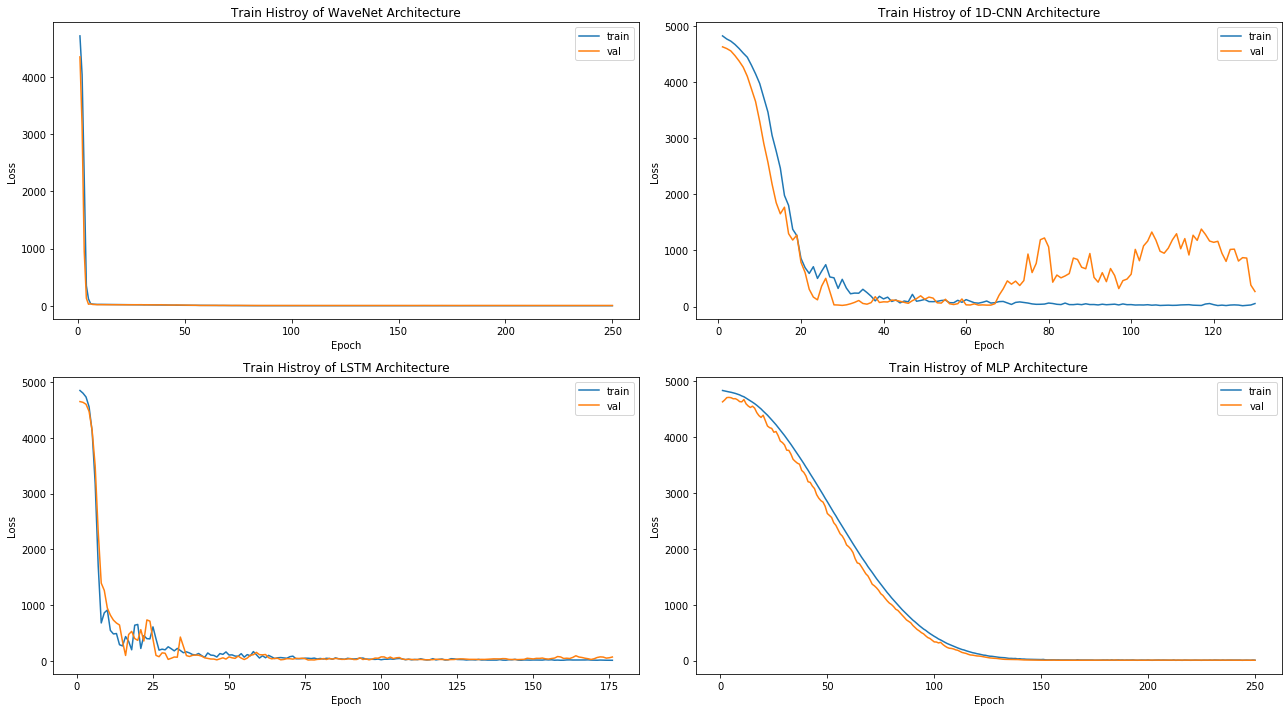

In [185]:
# plot training history for every model
fig, ax = plt.subplots(2, 2, figsize=(18,10))
plot_model_history(history_wavenet, ax = ax[0,0], plttitle='Train Histroy of WaveNet Architecture')
plot_model_history(history_cnn1D, ax = ax[0,1], plttitle='Train Histroy of 1D-CNN Architecture')
plot_model_history(history_lstm, ax = ax[1,0], plttitle='Train Histroy of LSTM Architecture')
plot_model_history(history_mlp, ax = ax[1,1], plttitle='Train Histroy of MLP Architecture')
plt.tight_layout()

### Evaluate performance of models

WaveNet Train Score: 0.85 MSE (0.92 RMSE)
WaveNet Test Score: 20.69 MSE (4.55 RMSE)
1D-CNN Train Score: 154.43 MSE (12.43 RMSE)
1D-CNN Test Score: 234.81 MSE (15.32 RMSE)
LSTM Train Score: 52.97 MSE (7.28 RMSE)
LSTM Test Score: 26.36 MSE (5.13 RMSE)
MLP Train Score: 6.11 MSE (2.47 RMSE)
MLP Test Score: 14.85 MSE (3.85 RMSE)


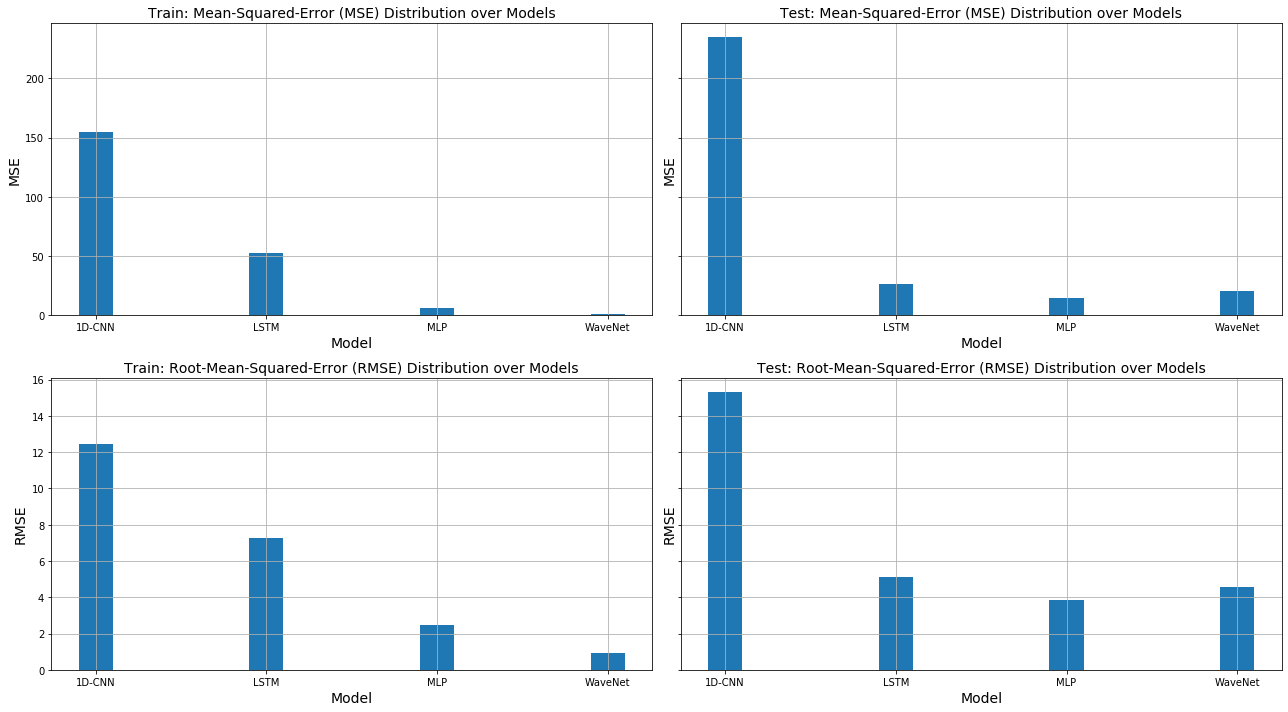

In [186]:
# WaveNet
trainScore_wavenet = wavenet.evaluate(X_train, y_train, verbose=0)
print('WaveNet Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_wavenet[0], math.sqrt(trainScore_wavenet[0])))
testScore_wavenet = wavenet.evaluate(X_test, y_test, verbose=0)
print('WaveNet Test Score: %.2f MSE (%.2f RMSE)' % (testScore_wavenet[0], math.sqrt(testScore_wavenet[0])))

# 1D-CNN
trainScore_cnn1D = cnn1D.evaluate(X_train, y_train, verbose=0)
print('1D-CNN Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_cnn1D[0], math.sqrt(trainScore_cnn1D[0])))
testScore_cnn1D = cnn1D.evaluate(X_test, y_test, verbose=0)
print('1D-CNN Test Score: %.2f MSE (%.2f RMSE)' % (testScore_cnn1D[0], math.sqrt(testScore_cnn1D[0])))

# LSTM
trainScore_lstm = lstm.evaluate(X_train, y_train, verbose=0)
print('LSTM Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_lstm[0], math.sqrt(trainScore_lstm[0])))
testScore_lstm = lstm.evaluate(X_test, y_test, verbose=0)
print('LSTM Test Score: %.2f MSE (%.2f RMSE)' % (testScore_lstm[0], math.sqrt(testScore_lstm[0])))

# MLP
trainScore_mlp = mlp.evaluate(X_train, y_train, verbose=0)
print('MLP Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_mlp[0], math.sqrt(trainScore_mlp[0])))
testScore_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print('MLP Test Score: %.2f MSE (%.2f RMSE)' % (testScore_mlp[0], math.sqrt(testScore_mlp[0])))

# Plot Errorbars (MSE & RMSE) for train and test
fig, ax = plt.subplots(2, 2, figsize=(18,10), sharey='row')

ax[0,0].bar([1,2,3,4], [trainScore_cnn1D[0], trainScore_lstm[0], trainScore_mlp[0], trainScore_wavenet[0]], width=0.2)
ax[0,0].set_title('Train: Mean-Squared-Error (MSE) Distribution over Models', fontsize=14)
ax[0,0].set_xlabel('Model', fontsize=14)
ax[0,0].set_ylabel('MSE', fontsize=14)
ax[0,0].set_xticks(np.arange(1,5))
ax[0,0].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[0,0].grid()

ax[1,0].bar([1,2,3,4], [math.sqrt(trainScore_cnn1D[0]), math.sqrt(trainScore_lstm[0]), math.sqrt(trainScore_mlp[0]), math.sqrt(trainScore_wavenet[0])], width=0.2)
ax[1,0].set_title('Train: Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=14)
ax[1,0].set_xlabel('Model', fontsize=14)
ax[1,0].set_ylabel('RMSE', fontsize=14)
ax[1,0].set_xticks(np.arange(1,5))
ax[1,0].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[1,0].grid()

ax[0,1].bar([1,2,3,4], [testScore_cnn1D[0], testScore_lstm[0], testScore_mlp[0], testScore_wavenet[0]], width=0.2)
ax[0,1].set_title('Test: Mean-Squared-Error (MSE) Distribution over Models', fontsize=14)
ax[0,1].set_xlabel('Model', fontsize=14)
ax[0,1].set_ylabel('MSE', fontsize=14)
ax[0,1].set_xticks(np.arange(1,5))
ax[0,1].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[0,1].grid()

ax[1,1].bar([1,2,3,4], [math.sqrt(testScore_cnn1D[0]), math.sqrt(testScore_lstm[0]), math.sqrt(testScore_mlp[0]), math.sqrt(testScore_wavenet[0])], width=0.2)
ax[1,1].set_title('Test: Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=14)
ax[1,1].set_xlabel('Model', fontsize=14)
ax[1,1].set_ylabel('RMSE', fontsize=14)
ax[1,1].set_xticks(np.arange(1,5))
ax[1,1].set_xticklabels(['1D-CNN', 'LSTM', 'MLP', 'WaveNet'])
ax[1,1].grid()

plt.tight_layout()

### Model prediction

In [187]:
# WaveNet
trainPredict_wavenet = wavenet.predict(X_train)
testPredict_wavenet = wavenet.predict(X_test)

# 1D-CNN
trainPredict_cnn1D = cnn1D.predict(X_train)
testPredict_cnn1D = cnn1D.predict(X_test)

# LSTM
trainPredict_lstm = lstm.predict(X_train)
testPredict_lstm = lstm.predict(X_test)

# MLP
trainPredict_mlp = mlp.predict(X_train)
testPredict_mlp = mlp.predict(X_test)

### Plot results

In [188]:
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Shift train predictions for plotting purposes
for t in range(len(trainPredict_wavenet)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict_wavenet[t, :]

# Shift test predictions for plotting purposes
for t in range(len(testPredict_wavenet)):
    #testPredictPlot[len(trainPredict_wavenet)+t+look_back:len(trainPredict_wavenet)+t+look_back+horizon] = testPredict_wavenet[t, :]
    testPredictPlot[len(trainPredict_wavenet)+t+look_back+horizon:len(trainPredict_wavenet)+
                    t+look_back+(horizon*2)] = testPredict_wavenet[t, :]

In [189]:
# Forecasting 'horizon'

forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

X_predict = np.zeros((1, look_back, X_train.shape[2]))
X_predict[0] = feature_data[len(feature_data)-look_back:, :]
prediction = wavenet.predict(X_predict)
forecastPlot[len(feature_data):len(feature_data)+horizon] = prediction[:]
print(f"Model forecast for the next {horizon} months: {np.around(prediction, 1)}")

Model forecast for the next 6 months: [[63.8 64.7 63.6 64.3 66.9 66.3]]


In [190]:
# Create time scope for final result plot

time_scope = []
for i in np.arange(int(first_date.split('/')[1]), int(last_date.split('/')[1])+1):
    for j in np.arange(1,13):
        time_scope.append(str(j)+"/"+str(i))

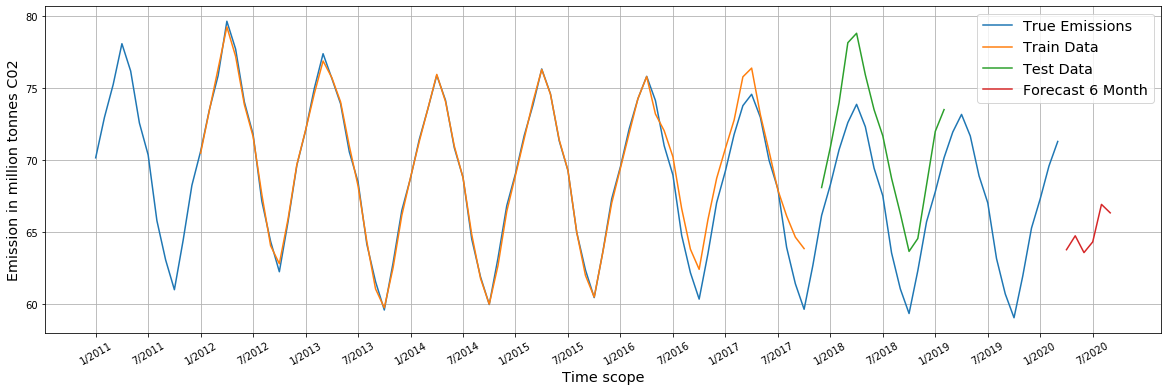

In [191]:
# Resulting plot: True Emissions, training data prediction, test data prediction, horizon forecast

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredictPlot[:], label='Train Data')
plt.plot(testPredictPlot[:], label='Test Data')
plt.plot(forecastPlot[:], label='Forecast 6 Month')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30)
plt.xlabel("Time scope", fontsize='x-large')
plt.ylabel("Emission in million tonnes C02", fontsize='x-large')
plt.legend(fontsize='x-large')
plt.grid()
plt.show()